In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing all relevent python libraries

import math
from scipy.spatial import distance as spa
import numpy as np
import time as time
from pyspark import SparkContext
import matplotlib.pyplot as plt 

In [ ]:
# initializing the spark context
sc = SparkContext()

In [ ]:
#splitting each value from each line
def split_line(row):
    values = row[0]
    index = row[1]
    li = values.split(" ")
    for i in range(len(li)):
        li[i] = float(li[i])
    return (index, li)

#loading the data from the file
def loadData(path):
    text = sc.textFile(path,2)
    data = text.filter(lambda x: x is not None).filter(lambda x: x != "")
    data_index = data.zipWithIndex()
    return data_index.map(lambda x: split_line(x))

In [ ]:
path = "/content/drive/My Drive/BIGDATA Fall2020/Project 3/data.txt"

#load data to the rdd
data_rdd = loadData(path)

#k clusters and i iterations
k = 10
I = 20

In [ ]:
#selecting centroids with euclidean distance
#get the farthest centroid from the selected group of centroids
def centroid_with_max_dist(x):
  arr = np.array(x[1])
  max_dist = -np.inf

  for item in bcentroids.value:
    index = item[0]
    centroid = np.array(item[1])
    dist = spa.euclidean(arr, centroid)
    
    if dist > max_dist:
      max_dist = dist**2
      farthest_centroid = index
  
  return (x[0],  max_dist)

#filtering appropritate centroids
def filter_centroids(x):
  if x[0] in bcentroids_keys.value:
    return ()
  else:
    return x

e_centroids = sc.parallelize(data_rdd.takeSample(False, 1))

#broadcasting the rdds
bcentroids_keys = sc.broadcast(e_centroids.keys().collect())
bcentroids = sc.broadcast(e_centroids.collect())

#loop for getting k centroids
for i in range(1,k):

  filtered_rdd = data_rdd.map(filter_centroids).filter(lambda x: x)
  max_dist = filtered_rdd.map(lambda x: centroid_with_max_dist(x))
  sum = max_dist.map(lambda x : x[1]).sum()
  max_dist = max_dist.map(lambda x : (x[0], x[1]/sum))

  max_dist_keys = max_dist.keys().collect()
  max_dist_values = max_dist.values().collect()

  rand = np.random.choice(max_dist_keys, 1, p=max_dist_values)

  new_centroid = filtered_rdd.filter(lambda x : x[0] == rand)
  e_centroids = e_centroids.union(new_centroid)
  
  bcentroids_keys = sc.broadcast(e_centroids.keys().collect())
  bcentroids = sc.broadcast(e_centroids.collect())

In [ ]:
print("Initial Centroids with euclidian distance:\n")
for item in e_centroids.collect():
  print(item)

Initial Centroids with euclidian distance:

(2593, [0.0, 0.0, 0.18, 0.0, 0.0, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.94, 0.37, 0.0, 0.0, 0.0, 0.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84, 0.0, 0.0, 0.47, 0.09, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.052, 0.065, 0.0, 0.0, 0.0, 0.0, 2.022, 19.0, 451.0, 0.0])
(3301, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.94, 0.0, 0.0, 0.0, 0.0, 2.94, 0.0, 2.94, 0.0, 0.0, 0.0, 0.0, 0.0, 2.94, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.94, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 10.0, 0.0])
(1847, [0.08, 0.16, 0.08, 0.0, 0.2, 0.0, 0.04, 0.04, 0.04, 0.49, 0.12, 0.32, 0.12, 0.04, 0.0, 0.08, 0.0, 0.0, 0.77, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 0.65, 0.0, 0.0, 0.04, 0.0, 0.08, 0.0, 0.16, 0.0, 0.28, 0.0, 0.89, 0.016, 0.243, 0.0, 0.033, 0.0, 0.016, 2.747, 86.0, 1995.0, 0.0])


In [ ]:
#centroids selection with manhattan distance
#selecting farthest centroid
def centroid_with_max_dist(x):
  arr = np.array(x[1])
  max_dist = -np.inf
  
  for item in bcentroids.value:
    index = item[0]
    centroid = np.array(item[1])
    dist = spa.cityblock(arr, centroid)
    
    if dist > max_dist:
      max_dist = dist**2
      farthest_centroid = index
  
  return (x[0],  max_dist)

#filtering the centroids
def filter_centroids(x):
  if x[0] not in bcentroids_keys.value:
    return x

m_centroids = sc.parallelize(data_rdd.takeSample(False, 1))

#broadcasting the centroids
bcentroids_keys = sc.broadcast(m_centroids.keys().collect())
bcentroids = sc.broadcast(m_centroids.collect())

for i in range(1,k):

  filtered_rdd = data_rdd.map(filter_centroids).filter(lambda x: x)
  max_dist = filtered_rdd.map(lambda x: centroid_with_max_dist(x))
  sum = max_dist.map(lambda x : x[1]).sum()
  max_dist = max_dist.map(lambda x : (x[0], x[1]/sum))

  max_dist_keys = max_dist.keys().collect()
  max_dist_values = max_dist.values().collect()

  rand = np.random.choice(max_dist_keys, 1, p=max_dist_values)

  new_centroid = filtered_rdd.filter(lambda x : x[0] == rand)
  m_centroids = m_centroids.union(new_centroid)
  
  bcentroids_keys = sc.broadcast(m_centroids.keys().collect())
  bcentroids = sc.broadcast(m_centroids.collect())

In [ ]:
print("Initial Centroids with manhattan distance:\n")
for item in m_centroids.collect():
  print(item)

Initial Centroids with manhattan distance:

(2613, [0.0, 0.0, 0.8, 0.0, 2.42, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 5.26, 0.0, 1.61, 0.0, 0.0, 0.0, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.27, 0.0, 0.0, 2.36, 35.0, 59.0, 0.0])
(1753, [0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.024, 9.752, 0.003, 1.542, 1.785, 1.998, 239.571, 9989.0, 10062.0, 1.0])
(2300, [0.0, 0.0, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.57, 0.0, 0.57, 0.0, 0.0, 0.0, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.73, 0.0, 0.0, 0.0, 0.0, 0.0, 0.093, 0.0, 0.0, 0.0, 0.0, 1.136, 3.0, 25.0, 0.0])
(2397, [0.0, 

In [ ]:
#assign cluster the appropriate centroid
def assign_cluster(e_centroids, m_centroids, data):
  e_centroids_data = e_centroids.cartesian(data)
  m_centroids_data = m_centroids.cartesian(data)
  e_centroids = e_centroids_data.map(lambda x: calculate_distance_euclidien(x[0], x[1]))
  m_centroids = m_centroids_data.map(lambda x: calculate_distance_manhattan(x[0], x[1]))
  e_updated = e_centroids.groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda x: compute_least_distance(x))
  m_updated = m_centroids.groupByKey().map(lambda x: (x[0], list(x[1]))).map(lambda x: compute_least_distance(x))

  return e_updated, m_updated

#compute the euclidean distance
def calculate_distance_euclidien(centroid_tup, data_tup):
    li_centroid = np.array(centroid_tup[1])
    li_data = np.array(data_tup[1])
    edistance = spa.euclidean(li_centroid, li_data)
    return (data_tup[0], (centroid_tup[0], edistance))

#compute the manhattan distance
def calculate_distance_manhattan(centroid_tup, data_tup):
    li_centroid = np.array(centroid_tup[1])
    li_data = np.array(data_tup[1])
    edistance = spa.cityblock(li_centroid, li_data)
    return (data_tup[0], (centroid_tup[0], edistance))

#compute the minimum distance
def compute_least_distance(row):
    least = -1
    nearest = None
    closest = -1
    target = row[0]
    centroids_li = row[1]
    
    for item in centroids_li:
        centroid = item[0]
        distance = item[1]
        if (least == -1) or (distance < least):
            least = distance
            closest = centroid
            nearest = (closest, least)
    return (target, nearest)

In [ ]:
#computing single centroid
def single_centroid(centroid_index, cluster_elements):
    all_cluster_elements = []
    for element in cluster_elements:
        all_cluster_elements.append(element[0])
    averageArray = list(np.average(all_cluster_elements, axis = 0))
    single = (centroid_index, averageArray)
    return single

#fucntion to get all centroids
def get_centroids(dataMinDistance):
  dataByCluster = dataMinDistance.join(data_rdd).map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1])))
  dataByCluster = dataByCluster.groupByKey().map(lambda x: (x[0], list(x[1])))
  newCentroids = dataByCluster.map(lambda x: single_centroid(x[0], x[1]))    
  return newCentroids


In [ ]:
#getting distance between the clusters
def get_cluster_seperation(data):
  clusters_rdd = data.map(lambda x : x[1])
  cluster_distance_rdd = clusters_rdd.map(lambda x: (x[0],(x[1],1)))
  temp_cluster_distance_rdd = cluster_distance_rdd.reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
  avg_cluster_distance_rdd = temp_cluster_distance_rdd.map(lambda x: x[1][0]/x[1][1])
  seperation_value = avg_cluster_distance_rdd.sum()
  return seperation_value

In [ ]:
#cost array for both euclidean and manhattan distance
e_iter_cost = np.zeros((I,2))
m_iter_cost = np.zeros((I,2))

start = time.time()

for i in range(0,I):

  # assigns the data element to the respective cluster
  e_closest_cluster, m_closest_cluster =  assign_cluster(e_centroids, m_centroids, data_rdd)

  # Get the new centroids with euclidean and manhattan distance
  e_new_centroids = get_centroids(e_closest_cluster)
  m_new_centroids = get_centroids(m_closest_cluster)

  # calculating the distance between the clusters with euclidean and manhattan distance
  e_cluster_seperation = get_cluster_seperation(e_new_centroids)
  m_cluster_seperation = get_cluster_seperation(m_new_centroids)
  
  # calculating the cost function with euclidean distance
  e_assigned_clusters = e_closest_cluster.map(lambda x : x[1][1]**2)
  e_cost = e_assigned_clusters.sum()/1000

  # calculating the cost function with manhattan distance
  m_assigned_clusters = m_closest_cluster.map(lambda x : x[1][1]**2)
  m_cost = m_assigned_clusters.sum()/1000

  # The final values for plotting
  e_iter_cost[i,:] = np.array([i, e_cost])
  m_iter_cost[i,:] = np.array([i, m_cost])

  # using the new centroid to update the existing centroid
  e_centroids = sc.parallelize(e_new_centroids.collect())
  m_centroids = sc.parallelize(m_new_centroids.collect())

print('Execution finished in : %.3f' %(time.time() - start))


Execution finished in : 168.067


In [ ]:
#writing centroid data to the file

output1 = open("/content/drive/My Drive/BIGDATA Fall2020/Project 3/kmeanspp_k_centroids.txt", "a") 
output1.write("k centroids with euclidean distance are as follows\n\n")
for val in e_centroids.collect():
  output1.write(str(val))
  output1.write("\n")

output1.write("\n\n\n")

3

In [ ]:
output1.write("k centroids with manhattan distance are as follows\n\n")
for val in m_centroids.collect():
  output1.write(str(val))
  output1.write("\n")

output1.close()

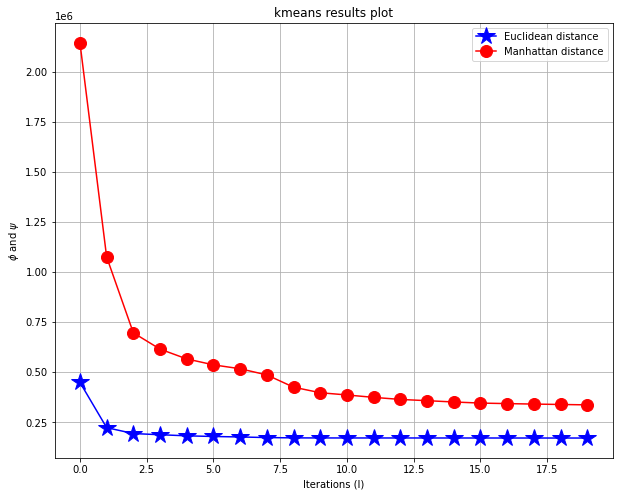

In [ ]:
figure, axes = plt.subplots(1,1,figsize=(10,8))            # setting up the plot parameters

axes.grid()
axes.plot(e_iter_cost[:,0], e_iter_cost[:,1], 'b*-',ms=18 , label='Euclidean distance') # plot with euclidean distance
axes.plot(m_iter_cost[:,0], m_iter_cost[:,1], 'ro-',ms=12 , label='Manhattan distance') # plot with manhattan distance
axes.set_title('kmeans results plot')
axes.set_xlabel('Iterations (I)')
axes.set_ylabel('$\phi$ and $\psi$')
axes.legend()

plt.show()

## Plot Reasoning 
After 10 iterations the curves representing the cost function with euclidean and manhattan distance is converging. This is because they found the appropriate centroids and there is very less change observed thereafter. 

In [ ]:
e_percent_change = (e_iter_cost[0][1] - e_iter_cost[10][1])/e_iter_cost[0][1]
print("Percentage change with the euclidean distance: " + str(e_percent_change*100))
m_percent_change = (m_iter_cost[0][1] - m_iter_cost[10][1])/m_iter_cost[0][1]
print("Percentage change with the manhattan distance: " + str(m_percent_change*100))

Percentage change with the euclidean distance: 61.74101031424638
Percentage change with the manhattan distance: 81.97844941412255


##Comparison of performance of kmeans and kmeans++
Though kmeans++ has overhead of computing initial k centroids it is faster than Kmeans because kmeans++ computes all k centroids at the beginning and chooses the most probable k centroids for the futher computation.
Hence it finds correct centroids with less number of iterations as compared to the kmeans algorithms or it converges in less number of iterations as compared to the kmeans algorithms.

After 10 iterations the percentage change in the kmeans++ should be ideally less as compared to the kmeans algorithm but some time the deviation in the result has been observed. This may happen if the initial cetroid selected in the kmeans++ is not closer to any of the final centroids. Typically 40% to 50% cost change has been observed for kmeans++ after 10 iterations and 50% to 60% has been observed for kmeans. 

## Contribution of team members: 
Prasad: Wrote logic for Kmeans algorithm and integrated the same code for Kmeans++.
 
Stevens: Wrote logic for computing Kmeans++ initial centroids with both euclidean and manhattan distance. Did graph work